# Data sourcing and preprocessing

As with any other Machine Learning application, the first step is to get and prepare the data for our models.
This notebook will focus in doing precisely this, explaining step by step the data obtained and using graphs to
 visualize these features. At the end of the notebook, we prepare clean data sets,
 which will be stored in the `data/` folder.


### What will we do?

Our goal will be to obtain and process the data, specifically:
- Use Quandl and yfinance to **source stock market, currencies and Bitcoin fundamentals.**
- **Calculate technical analysis indicators**, such as simple moving averages, relative strength index (RSI),
stochastic RSI, cumulated standard deviation and distance to prices.
- **Label data** necessary to provide trading signal predictions later. These labels were selected according to the
historical distribution of daily Bitcoin returns.
- **Create different plots, histograms and heatmaps** to have an initial feeling of how the features look like.
- **Join and clean up the datasets**
- **Store data** with and without transformations to feed in the relevant Azure service with appropiate data.

## Importing dependencies and utility functions

As described in our project proposal, we will first use historical data from financial data as our data inputs.
For this, we are going to use `yfinance` library, that scrapes this data from Yahoo Finance,
returning it as a pandas dataframe, which will facilitate most of this work, and also we'll use `quandl`.

However, since the tickers mostly have special signs and we want to create an object for each ticker historical data,
I'll first get the data and clear the name to get an appropiate object.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import yfinance as yf

# import cufflinks as cf
from matplotlib import pyplot as plt

from data_utils.transformations import lower_clean_name, change_name, min_max_scaler, back_min_max, \
    standardizer, back_standardizer, get_log_cumulative

from data_utils.settings import ma_values, rsi_values, ticker_list

## Data Sourcing

In [ ]:
signs = ['=','^','-','.']
labels = [lower_clean_name(word,signs) for word in ticker_list]
changed_labels = [change_name(x) for x in labels]

for x in range(len(labels)):
    print(labels[x] +' = '+changed_labels[x])

ticker_concat = " ".join(ticker_list)
ohlcv = yf.download(ticker_concat, start="2008-01-01", threads=False)
tickers = yf.download(ticker_concat, start="2008-01-01", group_by='tickers')

gspc = spy
ixic = nasdaq
gcf = gold
sif = silver
clf = crude oil
tnx = rates
btcusd = btc
n225 = nikkei
ftse = ftse
eurusdx = euro
000001ss = shangai
hsi = hsi
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  12 of 12 completed


In [ ]:
ohlcv.tail()

Adj Close                                                  \
              000001.SS       BTC-USD       CL=F  EURUSD=X         GC=F   
Date                                                                      
2022-01-27  3394.250000  37138.234375  86.610001  1.124354  1793.300049   
2022-01-28  3361.439941  37784.332031  86.820000  1.114703  1784.900024   
2022-01-29          NaN  38138.179688        NaN       NaN          NaN   
2022-01-30          NaN  37917.601562        NaN       NaN          NaN   
2022-01-31          NaN  37290.070312  87.389999  1.119445  1794.300049   

                                                                             \
                 SI=F        ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                                          
2022-01-27  22.673000  7554.299805  4326.509766  23807.000000  13352.780273   
2022-01-28  22.302000  7466.100098  4431.850098  23550.080078  13770.570312   
2022-01-29        NaN          NaN          NaN           NaN           NaN   
2022-01-30        NaN          NaN          NaN           NaN           NaN   
2022-01-31  22.514999  7476.959961          NaN  23802.259766           NaN   

                                       Close                           \
                   ^N225   ^TNX    000001.SS       BTC-USD       CL=F   
Date                                                                    
2022-01-27  26170.300781  1.807  3394.250000  37138.234375  86.610001   
2022-01-28  26717.339844  1.782  3361.439941  37784.332031  86.820000   
2022-01-29           NaN    NaN          NaN  38138.179688        NaN   
2022-01-30           NaN    NaN          NaN  37917.601562        NaN   
2022-01-31  27001.980469  1.807          NaN  37290.070312  87.389999   

                                                                        \
            EURUSD=X         GC=F       SI=F        ^FTSE        ^GSPC   
Date                                                                     
2022-01-27  1.124354  1793.300049  22.673000  7554.299805  4326.509766   
2022-01-28  1.114703  1784.900024  22.302000  7466.100098  4431.850098   
2022-01-29       NaN          NaN        NaN          NaN          NaN   
2022-01-30       NaN          NaN        NaN          NaN          NaN   
2022-01-31  1.119445  1794.300049  22.514999  7476.959961          NaN   

                                                                    High  \
                    ^HSI         ^IXIC         ^N225   ^TNX    000001.SS   
Date                                                                       
2022-01-27  23807.000000  13352.780273  26170.300781  1.807  3456.360107   
2022-01-28  23550.080078  13770.570312  26717.339844  1.782  3417.050049   
2022-01-29           NaN           NaN           NaN    NaN          NaN   
2022-01-30           NaN           NaN           NaN    NaN          NaN   
2022-01-31  23802.259766           NaN  27001.980469  1.807          NaN   

                                                                       \
                 BTC-USD       CL=F  EURUSD=X         GC=F       SI=F   
Date                                                                    
2022-01-27  37148.324219  88.540001  1.124480  1793.300049  23.030001   
2022-01-28  37952.878906  88.839996  1.117006  1798.400024  22.809999   
2022-01-29  38576.261719        NaN       NaN          NaN        NaN   
2022-01-30  38266.339844        NaN       NaN          NaN        NaN   
2022-01-31  37922.519531  88.160004  1.119570  1794.400024  22.655001   

                                                                  \
                  ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                               
2022-01-27  7596.700195  4428.740234  23952.009766  13765.910156   
2022-01-28  7554.299805  4432.720215  23848.019531  13771.910156   
2022-01-29          NaN          NaN           NaN           NaN   


In [ ]:
tickers.head()

GC=F                                                         \
                  Open        High         Low       Close   Adj Close Volume   
Date                                                                            
2007-12-31  843.200012  843.200012  843.200012  834.900024  834.900024    4.0   
2008-01-01         NaN         NaN         NaN         NaN         NaN    NaN   
2008-01-02  848.700012  857.799988  846.400024  857.000000  857.000000  130.0   
2008-01-03  863.000000  865.500000  856.299988  866.400024  866.400024  181.0   
2008-01-04  861.400024  865.500000  860.200012  863.099976  863.099976   28.0   

                   ^N225                                            \
                    Open          High           Low         Close   
Date                                                                 
2007-12-31           NaN           NaN           NaN           NaN   
2008-01-01           NaN           NaN           NaN           NaN   
2008-01-02           NaN           NaN           NaN           NaN   
2008-01-03           NaN           NaN           NaN           NaN   
2008-01-04  15155.730469  15156.660156  14542.580078  14691.410156   

                                            ^IXIC                            \
               Adj Close      Volume         Open         High          Low   
Date                                                                          
2007-12-31           NaN         NaN  2663.780029  2668.610107  2646.090088   
2008-01-01           NaN         NaN          NaN          NaN          NaN   
2008-01-02           NaN         NaN  2653.909912  2661.500000  2597.810059   
2008-01-03           NaN         NaN  2611.959961  2624.270020  2592.179932   
2008-01-04  14691.410156  98700000.0  2571.080078  2571.080078  2502.679932   

                                                      SI=F                  \
                  Close    Adj Close        Volume    Open    High     Low   
Date                                                                         
2007-12-31  2652.280029  2652.280029  1.454550e+09  14.797  14.797  14.797   
2008-01-01          NaN          NaN           NaN     NaN     NaN     NaN   
2008-01-02  2609.629883  2609.629883  2.076690e+09  15.167  15.167  15.167   
2008-01-03  2602.679932  2602.679932  1.970200e+09  15.340  15.340  15.085   
2008-01-04  2504.649902  2504.649902  2.516310e+09  15.180  15.180  15.180   

                                      ^TNX                                 \
             Close Adj Close Volume   Open   High    Low  Close Adj Close   
Date                                                                        
2007-12-31  14.797    14.797   10.0  4.040  4.058  4.014  4.035     4.035   
2008-01-01     NaN       NaN    NaN    NaN    NaN    NaN    NaN       NaN   
2008-01-02  15.167    15.167    7.0  4.033  4.052  3.892  3.901     3.901   
2008-01-03  15.382    15.382  398.0  3.892  3.958  3.892  3.901     3.901   
2008-01-04  15.346    15.346   25.0  3.914  3.990  3.809  3.854     3.854   

                        CL=F                                               \
           Volume       Open        High        Low      Close  Adj Close   
Date                                                                        
2007-12-31    0.0  96.120003   96.779999  94.730003  95.980003  95.980003   
2008-01-01    NaN        NaN         NaN        NaN        NaN        NaN   
2008-01-02    0.0  96.050003  100.000000  96.050003  99.620003  99.620003   
2008-01-03    0.0  99.230003  100.089996  98.449997  99.180000  99.180000   
2008-01-04    0.0  99.169998   99.410004  97.099998  97.910004  97.910004   

                        000001.SS                                         \
              Volume         Open         High          Low        Close   
Date                                                                       
2007-12-31  108597.0          NaN          NaN          NaN          NaN   
2008-01-01  

In [ ]:
# Renaming columns to changed labels
for x in [ohlcv, tickers]:
    x.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)

open = ohlcv['open'].fillna(method='ffill')
high = ohlcv['high'].fillna(method='ffill')
low = ohlcv['low'].fillna(method='ffill')
close = ohlcv['close'].fillna(method='ffill')
volume = ohlcv['volume'].fillna(method='ffill')

In [ ]:
# ohlcv.columns

### Making prices comparable:
### Returns and cumulative returns

To make stock prices comparable, we first need to bring all of them into the same base.
For this, we will use the `daily returns` of holding this stock. This way, instead of comparing stocks
with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them
 to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.

<AxesSubplot:title={'center':'Returns, excluding BTC [$]'}, xlabel='Date'>

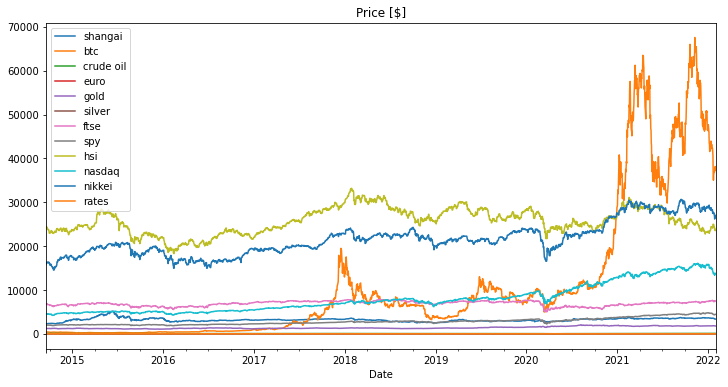

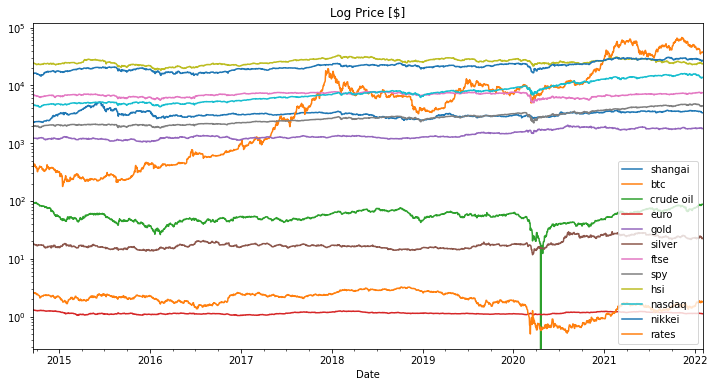

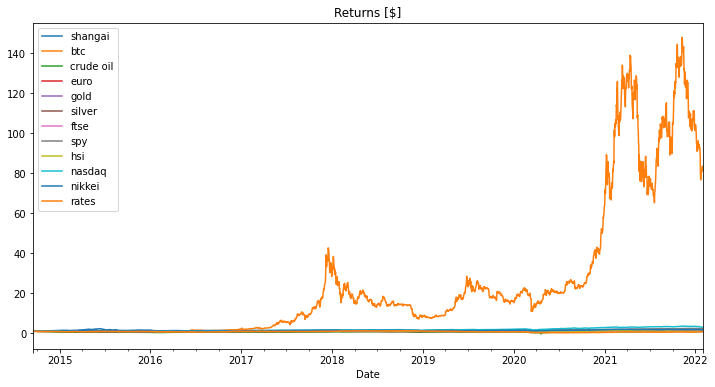

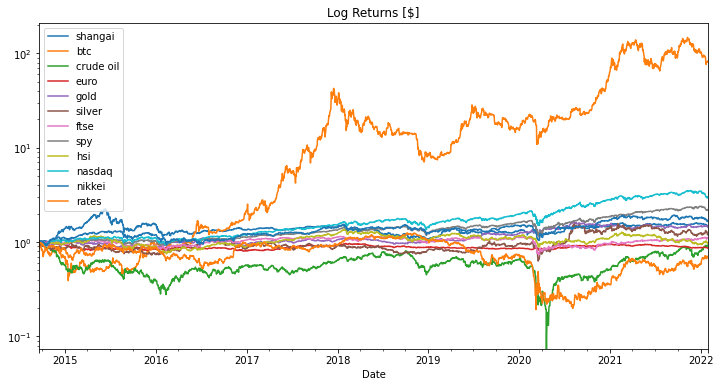

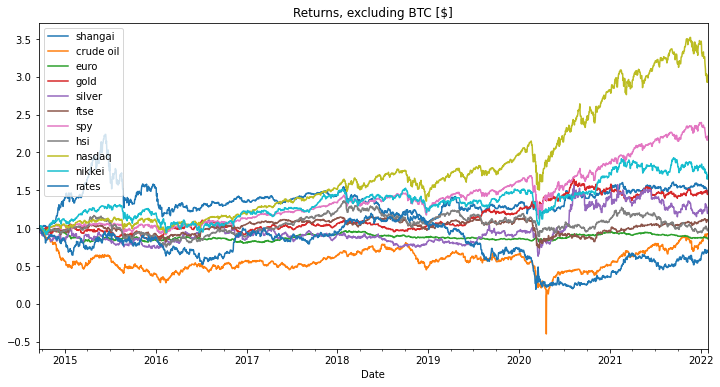

In [ ]:
close = close[close.btc.notnull()]
returns = close.pct_change(1)
cumulative = (1 + returns).cumprod()

# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)

close.plot(figsize=(12,6),label='Price', title='Price [$]')
close.plot(figsize=(12,6),label='Price (log scale)', logy=True, title='Log Price [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns', title='Returns [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns (log)', logy=True, title='Log Returns [$]')

cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), label='Cumulative Returns', title='Returns, excluding BTC [$]')

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

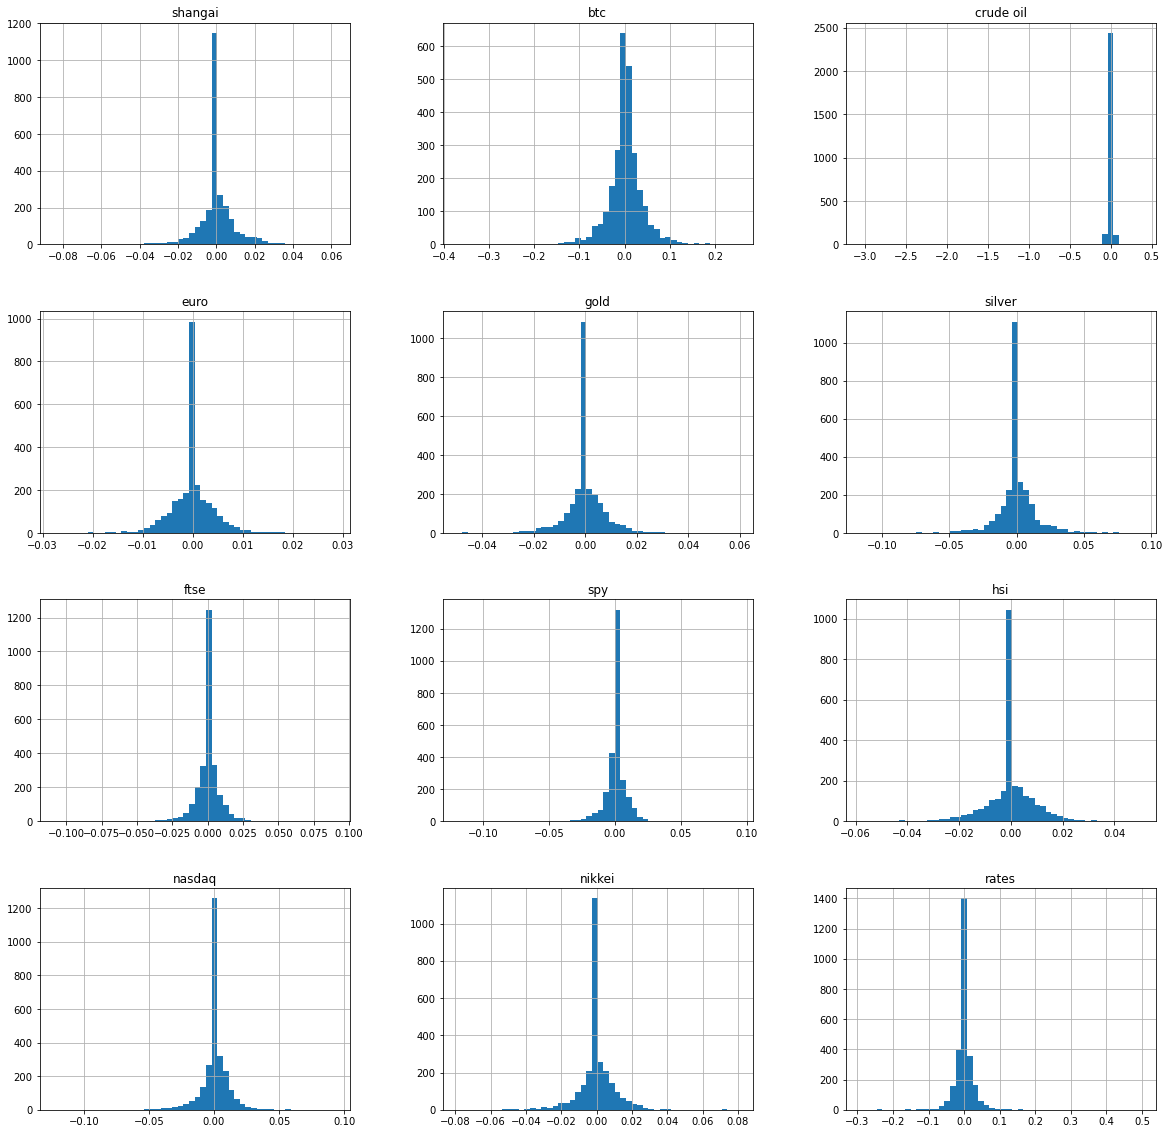

In [ ]:
returns.hist(bins=50, figsize=(20,20))

As returns have a normal distribution, log normality will be possible with closing prices, but we will dive deeper
 into the dopic further ahead.

## Technical Indicator functions
Now we will calculate several indicators typically used in technical analysis of stock prices,
such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a.
the expanding standard deviation of Bitcoin price.

In [ ]:
ta = tickers.btc

from data_utils.technical_analysis import transform_std, transform_ma, transform_rsi

### TODO for future improvement:
### Use vectorized functions for more speed.
ta = transform_std(transform_rsi(transform_ma(ta, ma_values[0], ma_values[1], ma_values[2])))
ta.tail()

/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma1)] = round(data['close'].rolling(ma1).mean(),0)
/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma2)] = round(data['close'].rolling(ma2).mean(),0)
/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:17: SettingWithCopyWarning: 
A value is trying t

,open,high,low,close,adj close,volume,MA4,MA50,MA80,change,cum_change,k,d,num,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1,btc_std_dev,btc_mean,std_dif
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,2.504143e+10,36900.0,44634.0,49573.0,0.007764,81.205931,0.007764,0.000000,0.006904,0.012965,0.532494,34.746872,10.413259,44.898193,70.563024,61.97,54.16,54.11,42.84,15939.541193,11069.412595,21198.693182
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,37784.332031,2.223883e+10,37182.0,44437.0,49208.0,0.017397,82.618679,0.017397,0.000000,0.008303,0.011237,0.738924,42.493185,10.413259,44.898193,93.025916,74.58,63.55,61.97,54.16,15944.896881,11079.340101,21839.435150
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,38138.179688,1.719418e+10,37478.0,44255.0,48872.0,0.009365,83.392397,0.009365,0.000000,0.008445,0.009739,0.867143,46.442228,10.413259,46.442228,100.000000,87.86,74.80,74.58,63.55,15950.462147,11089.391676,22187.717540
2022-01-30,38151.917969,38266.339844,37437.710938,37917.601562,37917.601562,1.464355e+10,37745.0,44026.0,48534.0,-0.005784,82.910084,0.000000,0.005784,0.007319,0.009211,0.794546,44.275607,10.413259,46.442228,93.986449,95.67,86.04,87.86,74.80,15955.876727,11099.353878,21961.724836
2022-01-31,37922.519531,37922.519531,36747.328125,37290.070312,37290.070312,1.773409e+10,37783.0,43769.0,48199.0,-0.016550,81.537933,0.000000,0.016550,0.006343,0.010190,0.622482,38.366028,10.413259,46.442228,77.584150,90.52,91.35,95.67,86.04,15960.892430,11109.075747,21329.177883


In [ ]:
# selection of technical indicators to feed the model
ta = ta[['open', 'high', 'low', 'close',
           f'MA{ma_values[0]}',f'MA{ma_values[1]}', f'MA{ma_values[2]}',
           'stochRSI', 'RSI','btc_std_dev','std_dif']].fillna(method='bfill')

### Exploring volume data

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

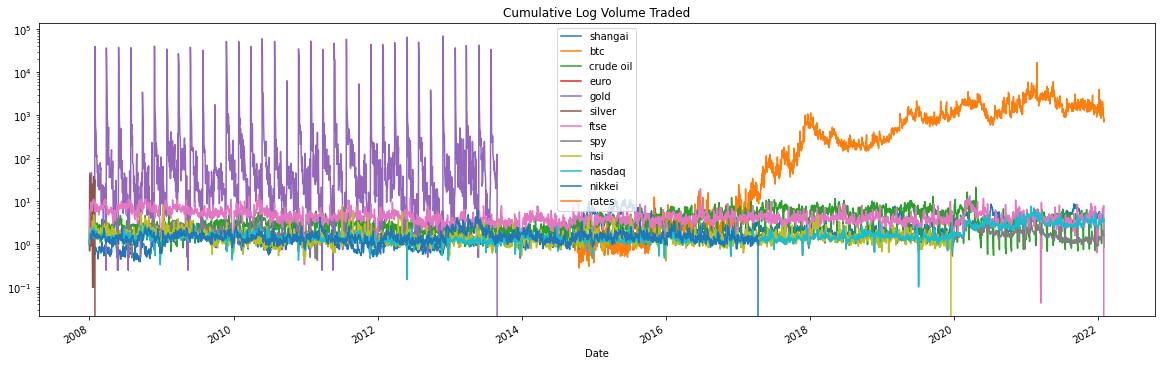

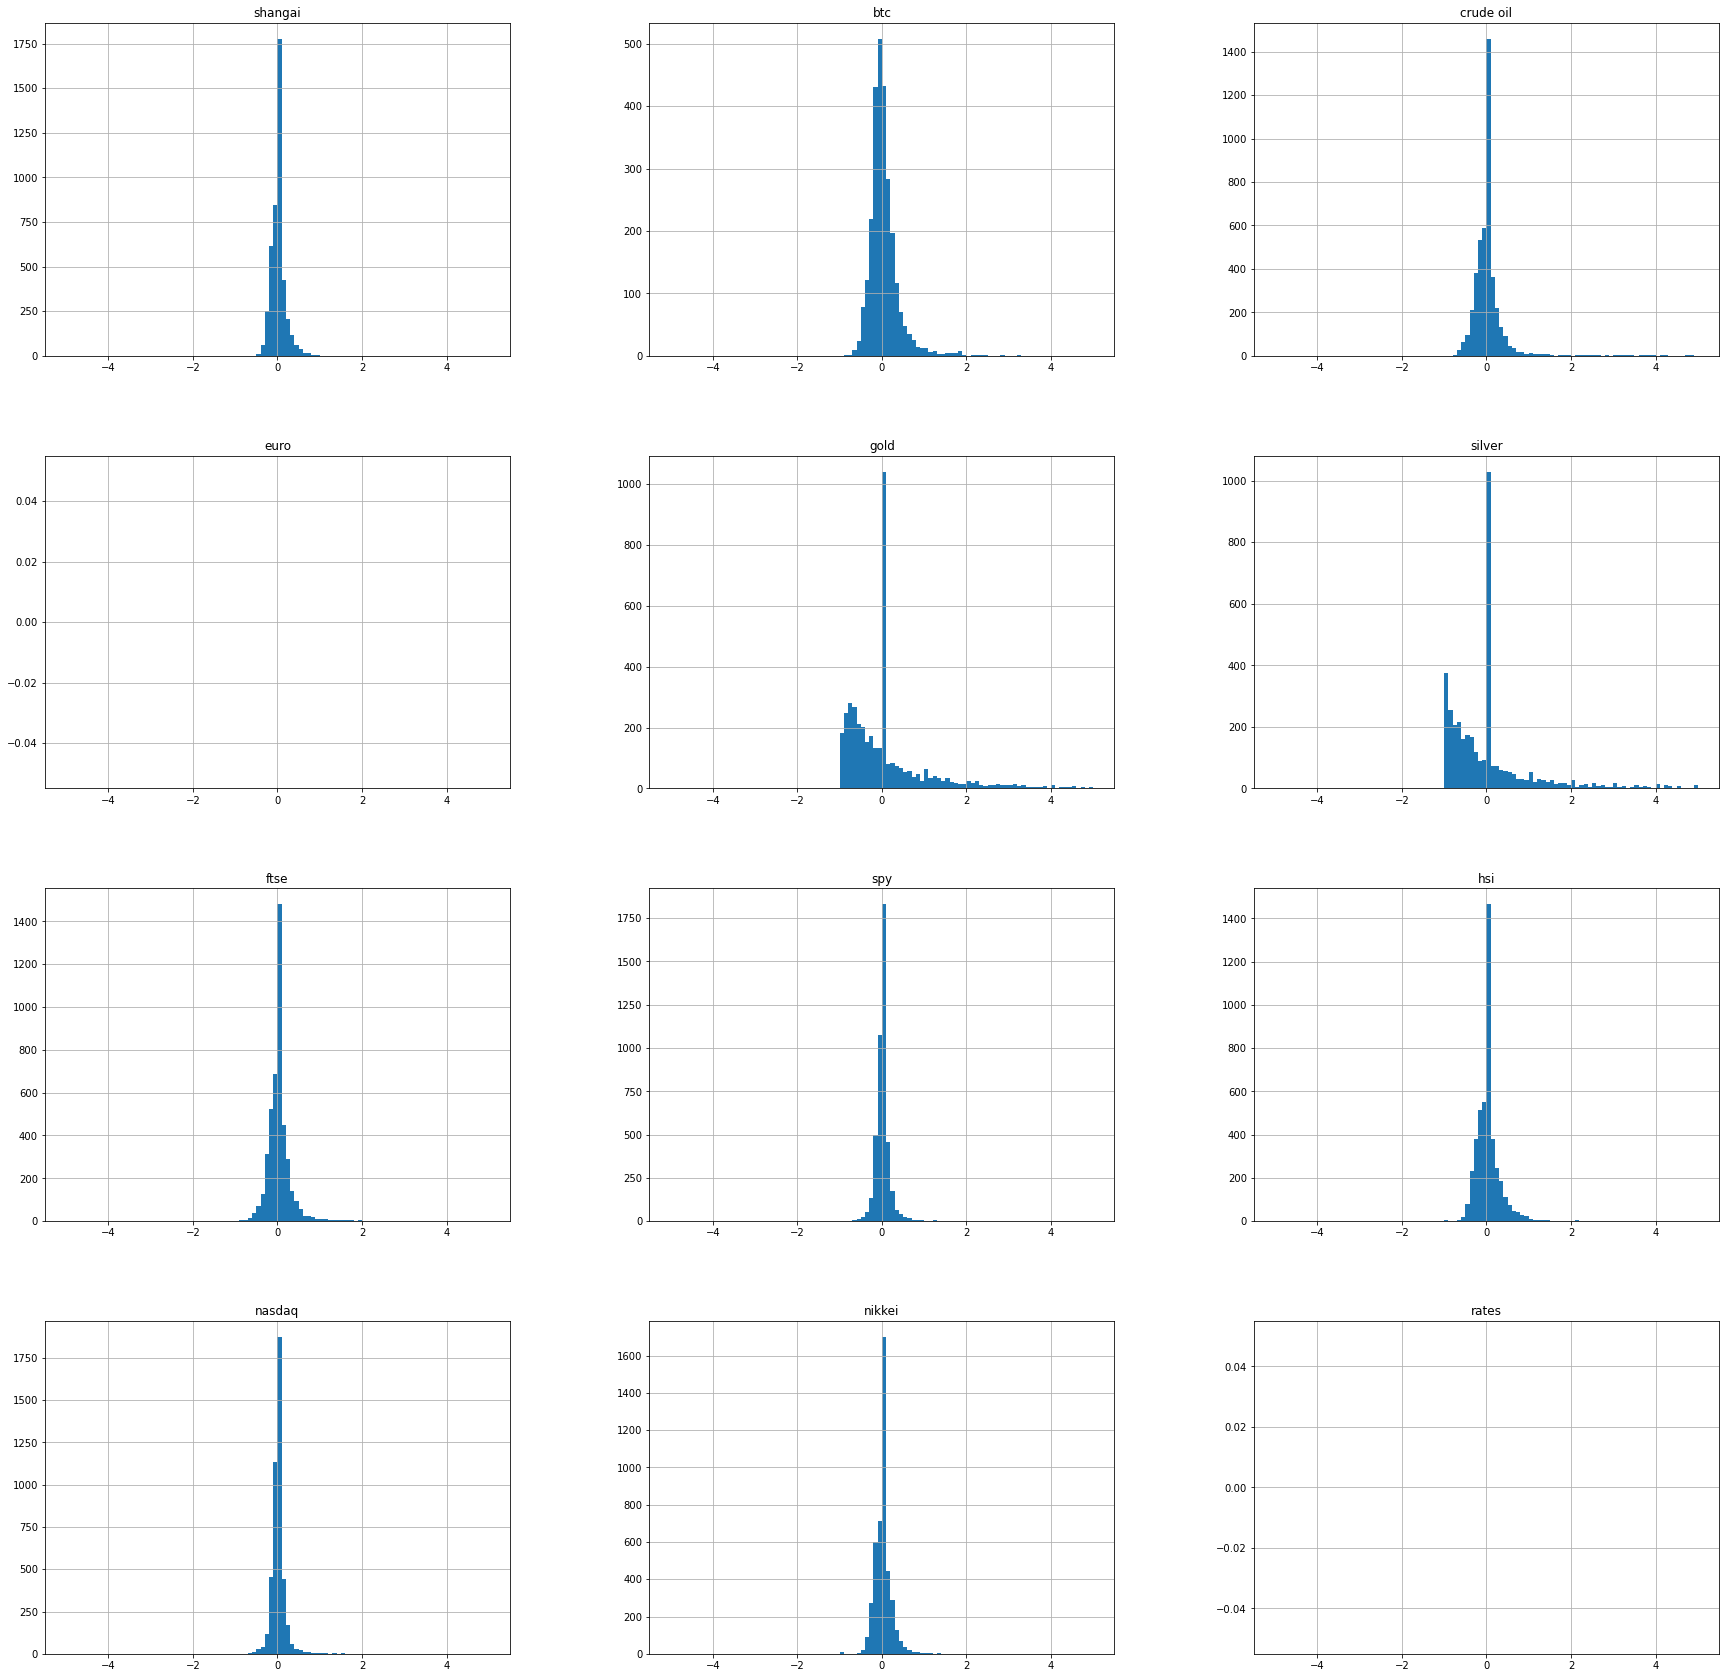

In [ ]:
# volume.plot(logy=True, figsize=(20,6))
v_returns = volume.pct_change(1)
v_cumulative = (1+v_returns).cumprod()
v_cumulative.plot(logy=True, figsize=(20,6), title="Cumulative Log Volume Traded")
v_returns.hist(bins=100, figsize=(30,30), range=[-5, 5])

Ok volume data seems really interesting. However, gold and silver are skewed.
We also lack complete data of M2 money supply 'volume(?)' from 2014 onwards.

For the purpose of this capstone project, we will avoid including rates and the EUR/USD pair.

In [ ]:
volume.drop(columns=['rates', 'euro'], inplace=True)
volume.columns

Index(['shangai', 'btc', 'crude oil', 'gold', 'silver', 'ftse', 'spy', 'hsi',
       'nasdaq', 'nikkei'],
      dtype='object')

In [ ]:
volume.rename(columns = lambda x: "vol_" + x, inplace=True)
# volume.tail()

In [ ]:
volume.describe()

,vol_shangai,vol_btc,vol_crude oil,vol_gold,vol_silver,vol_ftse,vol_spy,vol_hsi,vol_nasdaq,vol_nikkei
count,4444.000000,2.694000e+03,4.446000e+03,4446.000000,4446.000000,4.446000e+03,4.446000e+03,4.444000e+03,4.446000e+03,4.442000e+03
mean,192593.339334,1.464561e+10,4.144388e+05,5857.827710,1789.856275,8.570748e+08,3.992227e+09,1.893222e+09,2.438295e+09,1.217398e+08
std,127486.974372,2.007003e+10,2.125423e+05,30689.698014,9861.331527,3.386827e+08,1.175785e+09,7.450351e+08,1.164641e+09,5.419510e+07
min,30400.000000,5.914570e+06,4.851600e+04,0.000000,0.000000,0.000000e+00,1.025000e+09,0.000000e+00,1.494100e+08,0.000000e+00
25%,102350.000000,7.866035e+07,2.593180e+05,41.000000,8.000000,6.577126e+08,3.273700e+09,1.421887e+09,1.790910e+09,7.870000e+07
50%,154800.000000,5.024519e+09,3.608870e+05,141.000000,42.000000,7.866144e+08,3.711070e+09,1.737977e+09,2.033415e+09,1.180000e+08
75%,247325.000000,2.453245e+10,5.470368e+05,474.000000,153.000000,9.746946e+08,4.440678e+09,2.172088e+09,2.482458e+09,1.499000e+08
max,857100.000000,3.509679e+11,2.288230e+06,386334.000000,170297.000000,3.761301e+09,1.145623e+10,9.799120e+09,1.110216e+10,5.952000e+08


The problem with using volume data, seems that it is that not all instruments have it available,
plus we are not sure whether this is on the same measure value (USD). For this we will only take BTC.

### Fundamental Bitcoin data

Fundamental Bitcoin's blockchain data will also be included, such as hashrate, mining difficulty,
(daily) number of transactions and cost per transaction.

In [ ]:
import quandl
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
quandl_key = os.getenv("QUANDLKEY")
quandl.ApiConfig.api_key = quandl_key # (insert if available, else there is a ratelimit)

In [ ]:
# print('This is your key!', quandl_key)

In [ ]:

# btc mining is an interesting source, but free data has not the same quality ;)

# btcmining = quandl.get('BITCOINWATCH/MINING') # total btc and marketcap, bad quality data
# btcmining.fillna(method='ffill').plot(legend=None, logy=True)

btc_hrate = quandl.get('BCHAIN/HRATE') # hashrate
btc_diff = quandl.get('BCHAIN/DIFF') # difficulty
btc_ntrat = quandl.get('BCHAIN/NTRAT') # number of transactions
btc_cptra = quandl.get('BCHAIN/CPTRA') # cost per transaction


# m2 = quandl.get("FED/M2_N_WM") # unfortunately M2 money supply free data does not meet quality standards
# m2.rename({"Value":"M2"})

# fundamentals.fillna(method='ffill')

### Joining the data into a single DataFrame

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,3394.250000,37138.234375,86.610001,1.124354,1793.300049,22.673000,7554.299805,4326.509766,23807.000000,13352.780273,26170.300781,1.807,36841.878906,37148.324219,35629.281250,37138.234375,36900.0,44634.0,49573.0,70.563024,34.746872,15939.541193,21198.693182,2.504143e+10,1.735016e+08,2.664319e+13,705895543.0,118.110639
2022-01-28,3361.439941,37784.332031,86.820000,1.114703,1784.900024,22.302000,7466.100098,4431.850098,23550.080078,13770.570312,26717.339844,1.782,37128.445312,37952.878906,36211.109375,37784.332031,37182.0,44437.0,49208.0,93.025916,42.493185,15944.896881,21839.435150,2.223883e+10,2.039637e+08,2.664319e+13,706150299.0,136.551536
2022-01-29,3361.439941,38138.179688,86.820000,1.114703,1784.900024,22.302000,7466.100098,4431.850098,23550.080078,13770.570312,26717.339844,1.782,37780.714844,38576.261719,37406.472656,38138.179688,37478.0,44255.0,48872.0,100.000000,46.442228,15950.462147,22187.717540,1.719418e+10,1.973415e+08,2.664319e+13,706415305.0,154.451324
2022-01-30,3361.439941,37917.601562,86.820000,1.114703,1784.900024,22.302000,7466.100098,4431.850098,23550.080078,13770.570312,26717.339844,1.782,38151.917969,38266.339844,37437.710938,37917.601562,37745.0,44026.0,48534.0,93.986449,44.275607,15955.876727,21961.724836,1.464355e+10,1.933682e+08,2.664319e+13,706645954.0,171.438947
2022-01-31,3361.439941,37290.070312,87.389999,1.119445,1794.300049,22.514999,7476.959961,4431.850098,23802.259766,13770.570312,27001.980469,1.807,37922.519531,37922.519531,36747.328125,37290.070312,37783.0,43769.0,48199.0,77.584150,38.366028,15960.892430,21329.177883,1.773409e+10,NaN,NaN,NaN,NaN


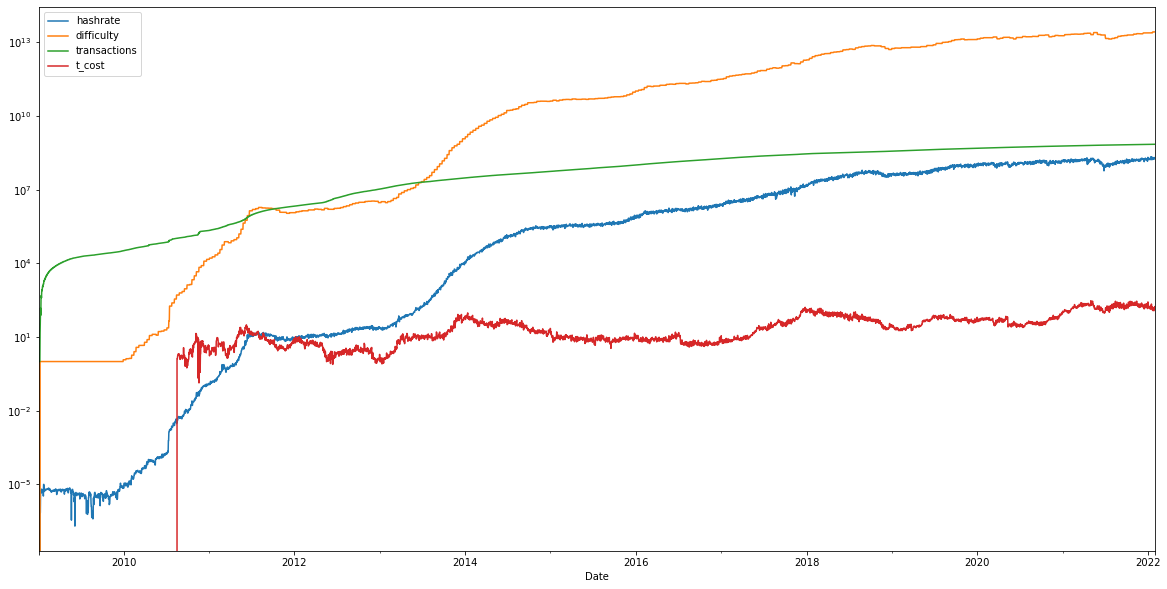

In [ ]:
df = pd.concat([close, ta], axis=1)
df = pd.concat([df, volume['vol_btc']], axis=1)

fundamentals = pd.concat([btc_hrate, btc_diff, btc_ntrat, btc_cptra], axis=1)
fundamentals.columns = ['hashrate','difficulty','transactions','t_cost'] #, 'm2']
fundamentals.plot(figsize=(20,10), logy=True)
df = pd.concat([df, fundamentals], axis=1)
# df.rename(columns={'btc':'btc_cumulative'}, inplace=True)

df.tail()

## Labelling buy, sell and no-trade signals
Following our objective, we will need to predict whether prices are going to go up or down.
For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy,
 down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

We will need to shift by one this values to become the predicted labels of our trained model.

In [ ]:
returns.btc.describe()

count    2693.000000
mean        0.002397
std         0.038843
min        -0.371695
25%        -0.013140
50%         0.001988
75%         0.018261
max         0.252472
Name: btc, dtype: float64

Given the confidence intervals above, I will take the top 75% interval as buy label (1),
the lowest 25% for the sell label (2), and the values in between as no-trade (0).
The objective of the classification problem will be to **predict the next day's label to give a trading signal**.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          1.,   2.,   0.,   2.,   1.,   4.,   2.,   1.,   7.,   7.,  13.,
          5.,   9.,   9.,  15.,  18.,  39.,  30.,  33.,  44.,  55.,  78.,
         98., 124., 162., 281., 359., 304., 238., 149., 127.,  91.,  74.,
         67.,  50.,  35.,  24.,  24.,  22.,  13.,   8.,   7.,  16.,   8.,
          7.,   6.,   3.,   3.,   1.,   0.,   2.,   3.,   0.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.37169539, -0.36545371, -0.35921204, -0.35297037, -0.3467287 ,
        -0.34048703, -0.33424536, -0.32800369, -0.32176202, -0.31552035,
        -0.30927868, -0.30303701, -0.29679534, -0.29055367, -0.28431199,
        -0.27807032, -0.27182865, -0.26558698, -0.25934531, -0.25310364,
        -0.24686197, -0.24

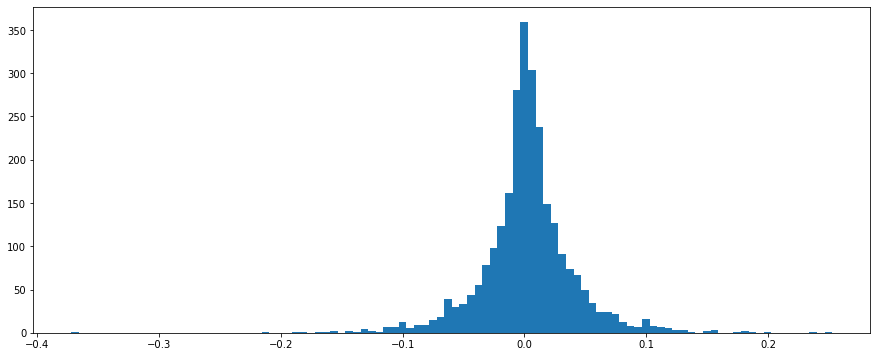

In [ ]:
plt.figure(figsize = (15,6))
plt.hist(returns.btc, bins=100)

In [ ]:
print(log_cumulative.columns)
# log_cumulative.tail()

Index(['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy',
       'hsi', 'nasdaq', 'nikkei', 'rates'],
      dtype='object')


### Creating labels

In [ ]:
labels = pd.DataFrame(returns.btc)
labels['y_returns'] = returns.btc
labels.drop(columns=['btc'], inplace=True)
labels['y_close'] = ta.close

In [ ]:
print(labels.columns)
labels.tail()

Index(['y_returns', 'y_close'], dtype='object')


,y_returns,y_close
Date,,
2022-01-27,0.007764,37138.234375
2022-01-28,0.017397,37784.332031
2022-01-29,0.009365,38138.179688
2022-01-30,-0.005784,37917.601562
2022-01-31,-0.016550,37290.070312


In [ ]:
buy_cond = labels.y_returns > labels.y_returns.describe().loc['75%'] # returns.btc.describe()['75%']
sell_cond = labels.y_returns <  labels.y_returns.describe().loc['25%'] # -0.013636 # returns.btc.describe()['25%']

In [ ]:
labels['y_c'] = 0
labels['y_c'] = labels['y_c'].mask(buy_cond, 1)
labels['y_c'] = labels['y_c'].mask(sell_cond, -1)
labels.head()

labels['y_returns_shift'] = labels['y_returns'].shift(-1)

# Finally join our labels with the consolidated DataFrame
df = pd.concat([df,labels], axis=1)

### Data cleaning
I'll consider the minimal available records as starting point and select the training data.
Dates afterwards will be test data. We will also get rid of NA values that aren't useful for our analysis.

In [ ]:
# row data cleaning
print('df ', df.shape)
print(df.index.min())

print('labels ', labels.shape)
print(labels.index.min())

df  (5042, 32)
2007-12-31 00:00:00
labels  (2694, 4)
2014-09-17 00:00:00


In [ ]:
# Take the least available value
df = df[df.index.min():].dropna()
df.describe()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
count,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2.692000e+03,2.692000e+03,2.692000e+03,2.692000e+03,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000
mean,3188.276724,11103.307080,54.406304,1.143474,1409.833507,18.187811,6899.893534,2808.996639,25714.255272,7950.166141,21558.805890,1.964456,11091.176342,11390.256098,10759.345819,11103.307080,11082.385215,10727.300892,10457.322808,52.251023,55.063091,3396.266147,7713.274223,1.464989e+10,5.309323e+07,7.333513e+12,3.361289e+08,53.487017,0.002404,11103.307080,0.000371,0.002425
std,399.493983,15957.522012,13.157968,0.049646,256.147158,3.798664,543.656713,755.477998,2902.840490,3246.670772,3789.815334,0.643186,15954.826611,16385.030765,15455.645970,15957.522012,15935.605374,15540.525395,15167.145957,35.081003,17.890777,4003.780050,12426.028146,2.007542e+10,5.800631e+07,8.016282e+12,2.045652e+08,57.818449,0.038848,15957.522012,0.706975,0.038823
min,2289.865967,178.102997,-37.630001,1.039047,1050.800049,11.735000,4993.899902,1829.079956,18319.580078,4213.660156,14532.509766,0.499000,176.897003,211.731003,171.509995,178.102997,199.000000,232.000000,234.000000,0.000000,0.000000,19.012574,2.518605,5.914570e+06,2.205477e+05,2.982973e+10,4.694520e+07,3.442916,-0.371695,178.102997,-1.000000,-0.371695
25%,2929.019043,605.911255,45.939999,1.108998,1222.199951,15.685500,6527.899902,2128.969971,23631.874512,5144.467407,19069.992676,1.573750,604.661240,608.072250,600.189499,605.911255,604.750000,595.000000,585.500000,20.746378,42.344854,118.632727,373.116442,7.886805e+07,1.536420e+06,2.133989e+11,1.440415e+08,9.269859,-0.013140,605.911255,0.000000,-0.013140
50%,3159.100952,6278.660156,53.180000,1.133369,1293.350037,16.903000,7022.600098,2683.955078,25724.730469,7209.620117,21152.655273,2.054000,6275.390137,6396.064941,6130.469971,6278.660156,6293.000000,6210.000000,5857.500000,52.615021,54.176968,3620.633475,2755.775387,5.024519e+09,3.223433e+07,4.306950e+12,3.186013e+08,33.520772,0.001990,6278.660156,0.000000,0.001990
75%,3404.659912,10354.489258,62.967500,1.179457,1652.349976,18.632250,7334.700073,3130.010010,27990.865723,9121.320312,23140.207520,2.390000,10347.987793,10579.521240,10120.704590,10354.489258,10354.000000,10272.750000,10073.250000,85.598637,68.276026,3990.240609,6542.451214,2.454922e+10,1.051669e+08,1.471521e+13,5.159995e+08,65.590429,0.018261,10354.489258,0.250000,0.018261
max,5166.350098,67566.828125,94.570000,1.292006,2051.500000,29.398001,7877.500000,4796.560059,33154.121094,16057.440430,30670.099609,3.234000,67549.734375,68789.625000,66382.062500,67566.828125,66121.000000,60802.000000,56971.000000,100.000000,98.422025,15955.876727,53525.381373,3.509679e+11,2.168643e+08,2.664319e+13,7.066460e+08,300.310549,0.252472,67566.828125,1.000000,0.252472


In [ ]:
df.head()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-18,2315.927979,424.440002,93.070000,1.285000,1225.699951,18.452000,6819.299805,2011.359985,24168.720703,4593.430176,16067.570312,2.629,456.859985,456.859985,413.104004,424.440002,421.0,373.0,373.0,63.913817,0.000000,23.259579,401.180423,34483200.0,240220.740405,2.982973e+10,46945196.0,29.138967,-0.071926,424.440002,-1.0,-0.069843
2014-09-19,2329.450928,394.795990,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,424.102997,427.834991,384.532013,394.795990,421.0,373.0,373.0,63.913817,0.000000,31.283084,363.512906,37919700.0,240220.740405,2.982973e+10,47136557.0,28.902143,-0.069843,394.795990,-1.0,0.035735
2014-09-20,2329.450928,408.903992,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,394.673004,423.295990,389.882996,408.903992,421.0,373.0,373.0,63.913817,23.777418,26.860222,382.043769,36863600.0,259497.713401,2.982973e+10,47199708.0,28.205716,0.035735,408.903992,1.0,-0.024659
2014-09-21,2329.450928,398.821014,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,408.084991,412.425995,393.181000,398.821014,407.0,373.0,373.0,63.913817,19.992515,25.353136,373.467879,26580100.0,232806.520022,2.982973e+10,47156242.0,29.910568,-0.024659,398.821014,-1.0,0.008352
2014-09-22,2289.865967,402.152008,91.519997,1.284142,1216.800049,17.698999,6773.600098,1994.290039,23955.490234,4527.689941,16205.900391,2.566,399.100006,406.915985,397.130005,402.152008,401.0,373.0,373.0,63.913817,24.678341,23.457930,378.694078,24127600.0,232806.520022,2.982973e+10,47339374.0,22.511639,0.008352,402.152008,0.0,0.083647


In [ ]:
# Fill NAs
df.fillna(method='ffill', inplace=True)

In [ ]:
df['y_c_shift'] = df['y_c'].shift(-1)
df['y_close_shift'] = df['y_close'].shift(-1)

df = df[:-2]
df.tail()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift,y_c_shift,y_close_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,3524.110107,36654.328125,83.309998,1.134147,1841.699951,23.795000,7297.200195,4410.129883,24656.460938,13855.129883,27588.369141,1.735,36275.734375,37247.519531,33184.058594,36654.328125,36105.0,45451.0,50591.0,46.991289,28.536396,15924.885075,20729.443050,4.185666e+10,1.986660e+08,2.664319e+13,705098842.0,124.481728,0.010407,36654.328125,0.0,0.008176,0.0,36954.003906
2022-01-25,3433.060059,36954.003906,85.599998,1.132413,1852.699951,23.896000,7371.500000,4356.450195,24243.609375,13539.290039,27131.339844,1.783,36654.804688,37444.570312,35779.429688,36954.003906,36229.0,45179.0,50284.0,55.185296,31.696579,15929.764641,21024.239265,2.642819e+10,2.013149e+08,2.664319e+13,705368879.0,132.340687,0.008176,36954.003906,0.0,-0.002757,0.0,36852.121094
2022-01-26,3455.669922,36852.121094,87.349998,1.130454,1829.900024,23.806999,7469.799805,4349.930176,24289.900391,13542.120117,27011.330078,1.848,36950.515625,38825.410156,36374.906250,36852.121094,36684.0,44902.0,49953.0,60.162978,31.160423,15934.571783,20917.549311,3.132460e+10,1.721772e+08,2.664319e+13,705634659.0,118.689025,-0.002757,36852.121094,0.0,0.007764,0.0,37138.234375
2022-01-27,3394.250000,37138.234375,86.610001,1.124354,1793.300049,22.673000,7554.299805,4326.509766,23807.000000,13352.780273,26170.300781,1.807,36841.878906,37148.324219,35629.281250,37138.234375,36900.0,44634.0,49573.0,70.563024,34.746872,15939.541193,21198.693182,2.504143e+10,1.735016e+08,2.664319e+13,705895543.0,118.110639,0.007764,37138.234375,0.0,0.017397,0.0,37784.332031
2022-01-28,3361.439941,37784.332031,86.820000,1.114703,1784.900024,22.302000,7466.100098,4431.850098,23550.080078,13770.570312,26717.339844,1.782,37128.445312,37952.878906,36211.109375,37784.332031,37182.0,44437.0,49208.0,93.025916,42.493185,15944.896881,21839.435150,2.223883e+10,2.039637e+08,2.664319e+13,706150299.0,136.551536,0.017397,37784.332031,0.0,0.009365,0.0,38138.179688


## Data transformations

In order to make try our best so that no feature becomes more important in the dataset than the others,
we will create functions to normalize these and bring them back to the dataset's original state.
This will be used later before saving the feed-in dataset.

We will be using log cumulative returns for price features, and normalize the oscillating factors (i.e. RSI)

<AxesSubplot:title={'center':'Cumulative Returns [$]'}, xlabel='Date'>

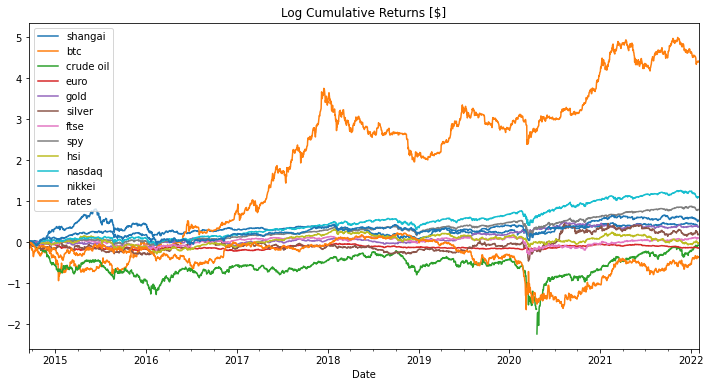

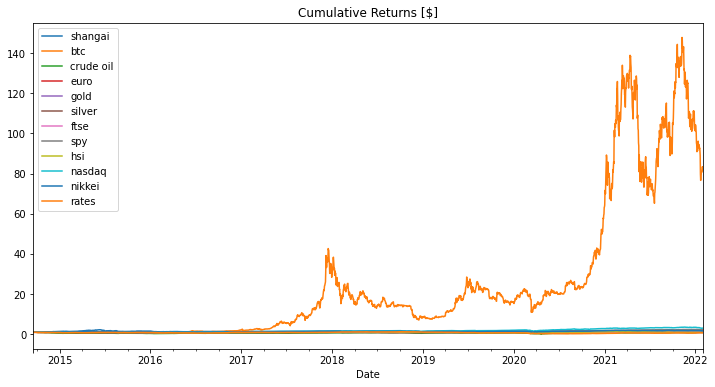

In [ ]:
# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)
# We can observe that log cumulative returns are reversible. This is useful for predicting price.
log_cumulative.loc[:,:].plot(
    figsize=(12,6), title='Log Cumulative Returns [$]')

np.exp(log_cumulative).plot(figsize=(12,6), title='Cumulative Returns [$]')

Here we will apply the mentioned transformation to features, in a sense que can
revert these to previous values. We will use normalization on log_cumulative (easing a lognormal step),
and normalize and standardize oscillators.

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

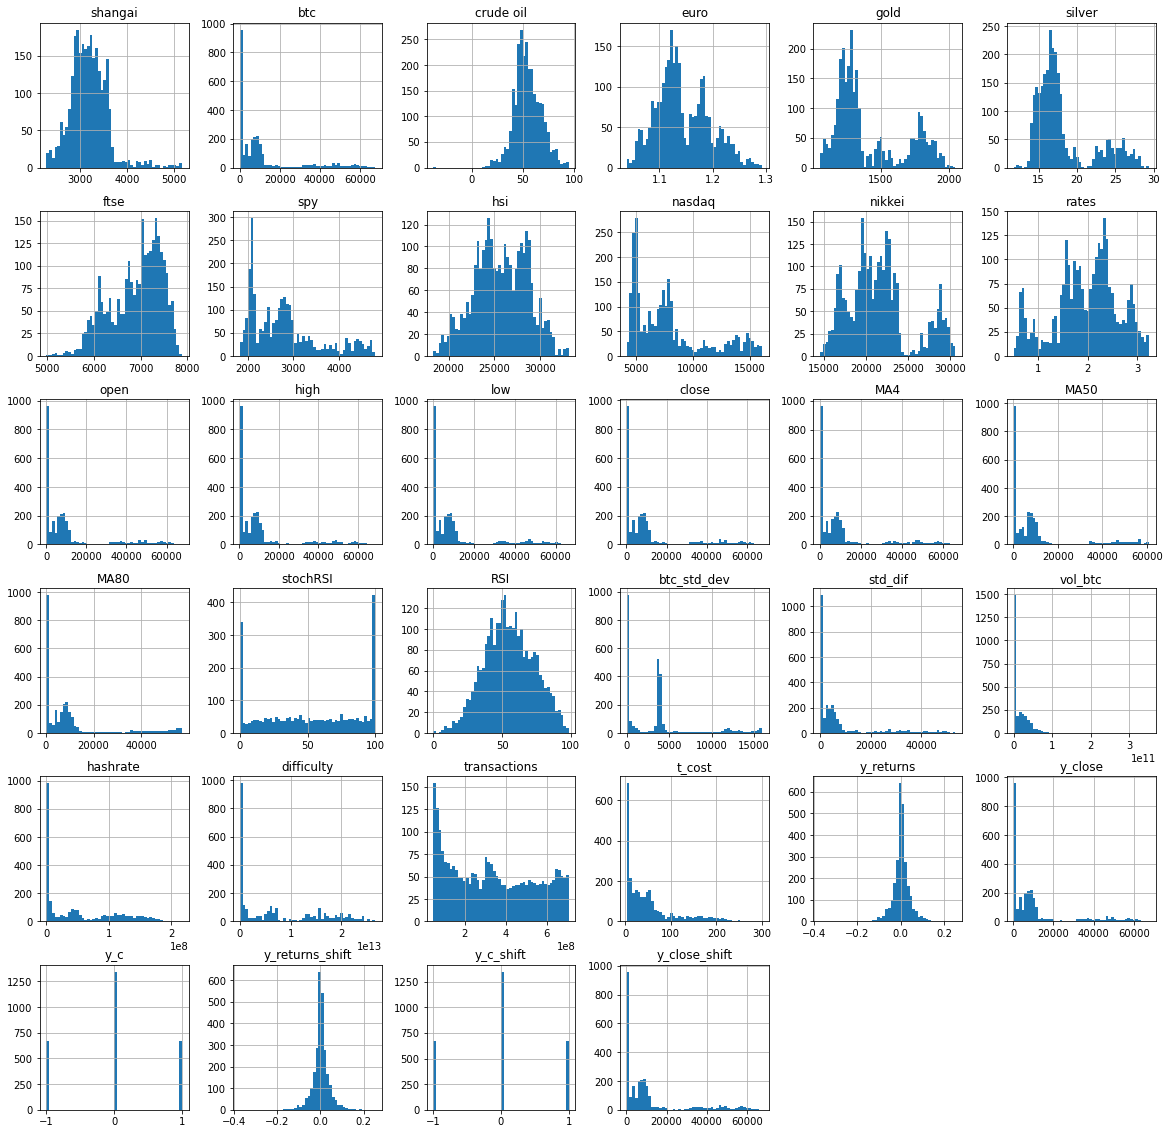

In [ ]:
# Have a look at the data
df.hist(bins=50, figsize=(20,20))

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

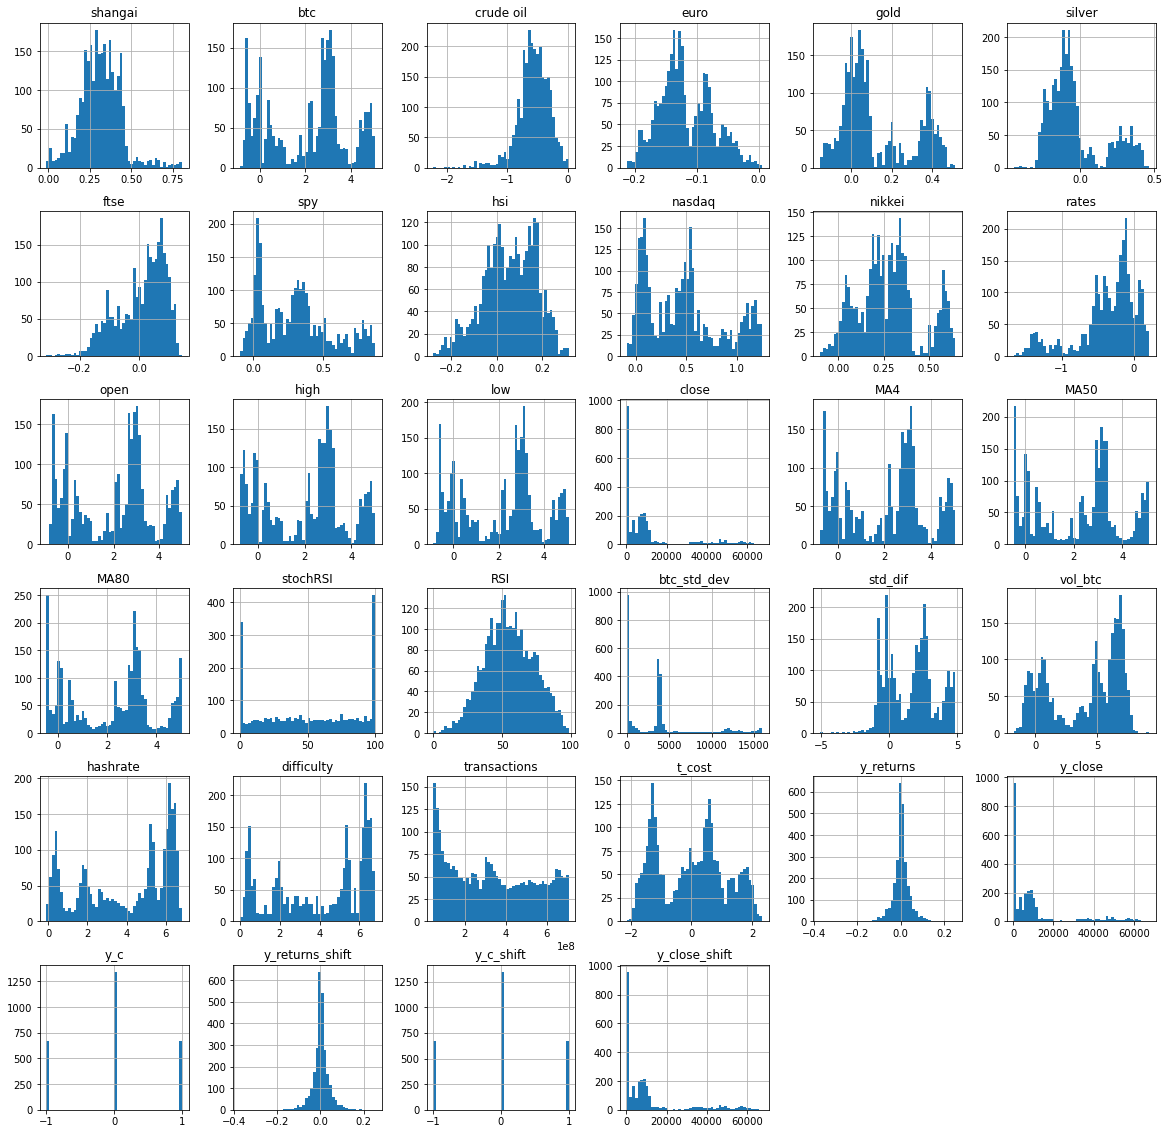

In [ ]:
# Take log cumulative returns of skewed features
cum_cols = list(close.columns) + ['open', 'high','low',
            'std_dif', f'MA{ma_values[0]}', f'MA{ma_values[1]}', f'MA{ma_values[2]}',
            'hashrate', 'difficulty', 't_cost', 'vol_btc']

# We will do transformations on a copy of the dataframe to preserve original data
ndf = df
ndf[cum_cols] = (1 + ndf[cum_cols].pct_change(1)).cumprod()
ndf[cum_cols] = np.log(ndf[cum_cols])

ndf.hist(bins=50, figsize=(20,20))

In [ ]:
# Drop columns that are not needed anymore
drop_cols = ['close']

for x in drop_cols:
    if x in ndf.columns:
        ndf.drop(columns=x, inplace=True)

In [ ]:
# Normalize what is needed
# norm_cols = ['']
# ndf[norm_cols], mindf, maxdf = min_max_scaler(ndf[norm_cols], log=False)

['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy', 'hsi', 'nasdaq', 'nikkei', 'rates', 'open', 'high', 'low', 'MA4', 'MA50', 'MA80', 'stochRSI', 'RSI', 'btc_std_dev', 'std_dif', 'vol_btc', 'hashrate', 'difficulty', 'transactions', 't_cost', 'y_c']


array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>,
        <AxesSubplot:title={'center':'MA80'}>],
       [<AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'}>,
        <AxesSubplot:title={'center':'btc_st

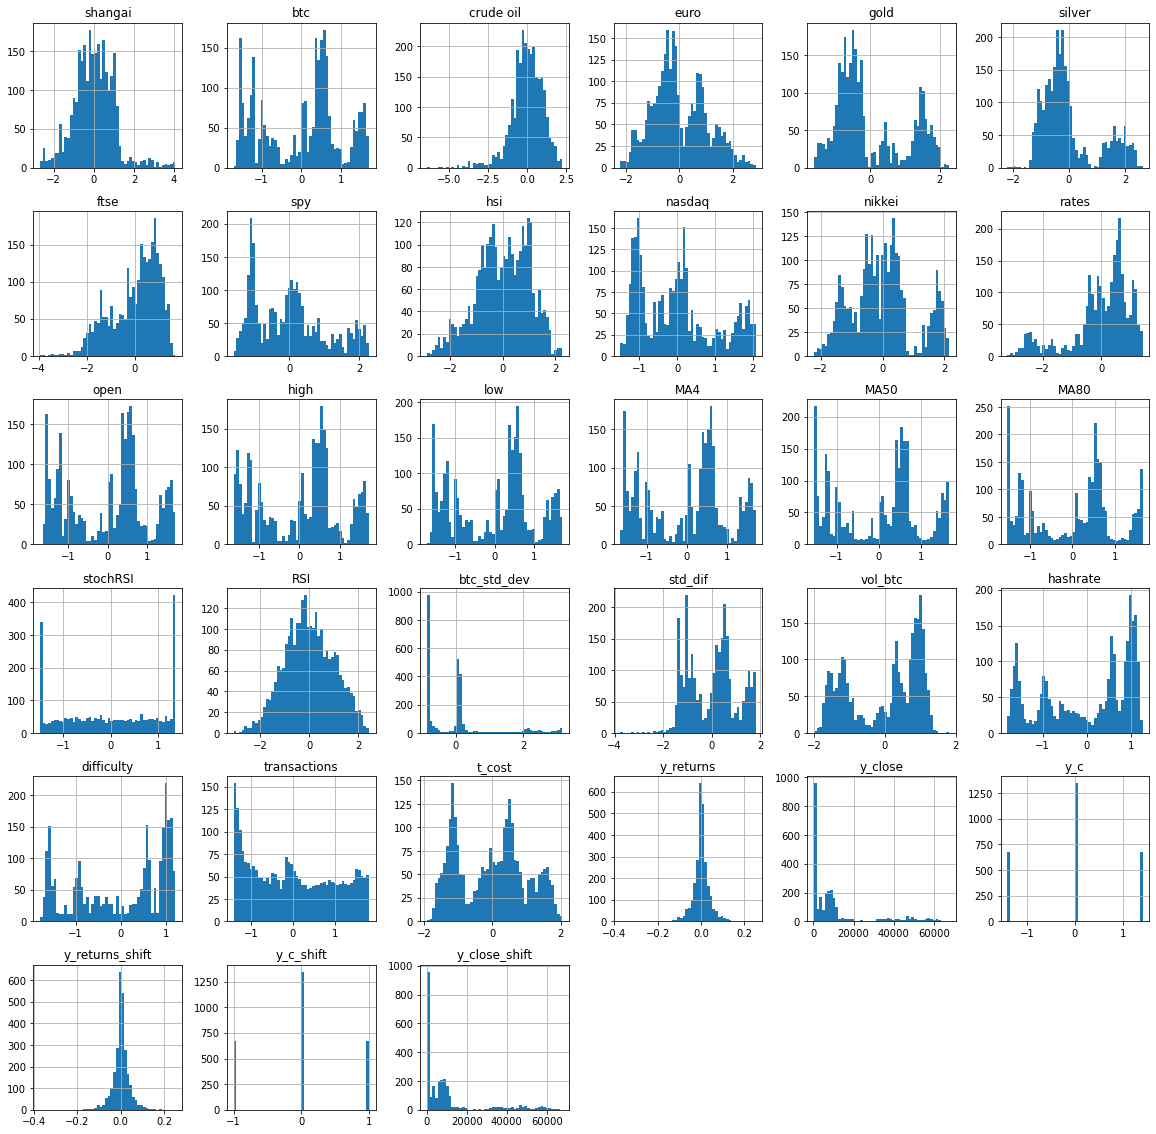

In [ ]:
# Standardize what needs to be. In this case, the whole dataset, except labels
s_cols = list(ndf.columns)
non_s_cols = ['y_close', 'y_returns', 'y_c_shift', 'y_close_shift', 'y_returns_shift']

for x in non_s_cols:
    s_cols.remove(x)

print(s_cols)
ndf[s_cols], mean, std = standardizer(ndf[s_cols], log=False)

ndf.hist(bins=50, figsize=(20,20))

In [1]:
# ndf.tail()

Our features look much better now! Did not do any transformations on the labels.

## Are these features correlated?

In [44]:
# Correlation of BTC with features
cor_list = df.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(
#     # index=['btc', 'open', 'high', 'low',
#     # 'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     # 'MA80', 'transactions', 'btc_std_dev',
#     # 'RSI', 'y_returns', 'y_returns_shift', 'stochRSI', 'y_close',
#     # 'y_returns', 'y_c_shift', 'difficulty', 'hashrate']
# )
print(cor_list)

btc                1.00
low                1.00
high               1.00
MA4                1.00
open               1.00
MA50               1.00
MA80               0.99
vol_btc            0.96
hashrate           0.95
difficulty         0.95
transactions       0.94
spy                0.94
nasdaq             0.94
t_cost             0.93
std_dif            0.92
nikkei             0.88
btc_std_dev        0.83
gold               0.80
y_close_shift      0.78
y_close            0.78
silver             0.60
hsi                0.58
euro               0.39
crude oil          0.32
ftse               0.30
shangai            0.07
y_returns          0.02
RSI                0.00
y_returns_shift   -0.00
y_c               -0.01
stochRSI          -0.02
y_c_shift         -0.02
rates             -0.33
Name: btc, dtype: float64


BTC price is *negatively correlated* to FED's interest rates, and very slightly to the target variables. It also seems
uncorrelated to the RSI and the shifted returns.

On the other hand, it is **strongly correlated** to its volume, other fundamentals seen above, as well as S&P and Nasdaq.

In [ ]:
# Normalized correlation does not change, uncomment below to see
# cor_list = ndf.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(index=['btc', 'open', 'high', 'low',
#     'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     'MA80', 'transactions', 'btc_std_dev',
#     'RSI', 'y_pnl', 'y_returns', 'y_returns_shift' 'stochRSI',
#     'returns_label', 'y_c_shift', 'difficulty', 'hashrate', 'log_btc_cumulative'])

<AxesSubplot:>

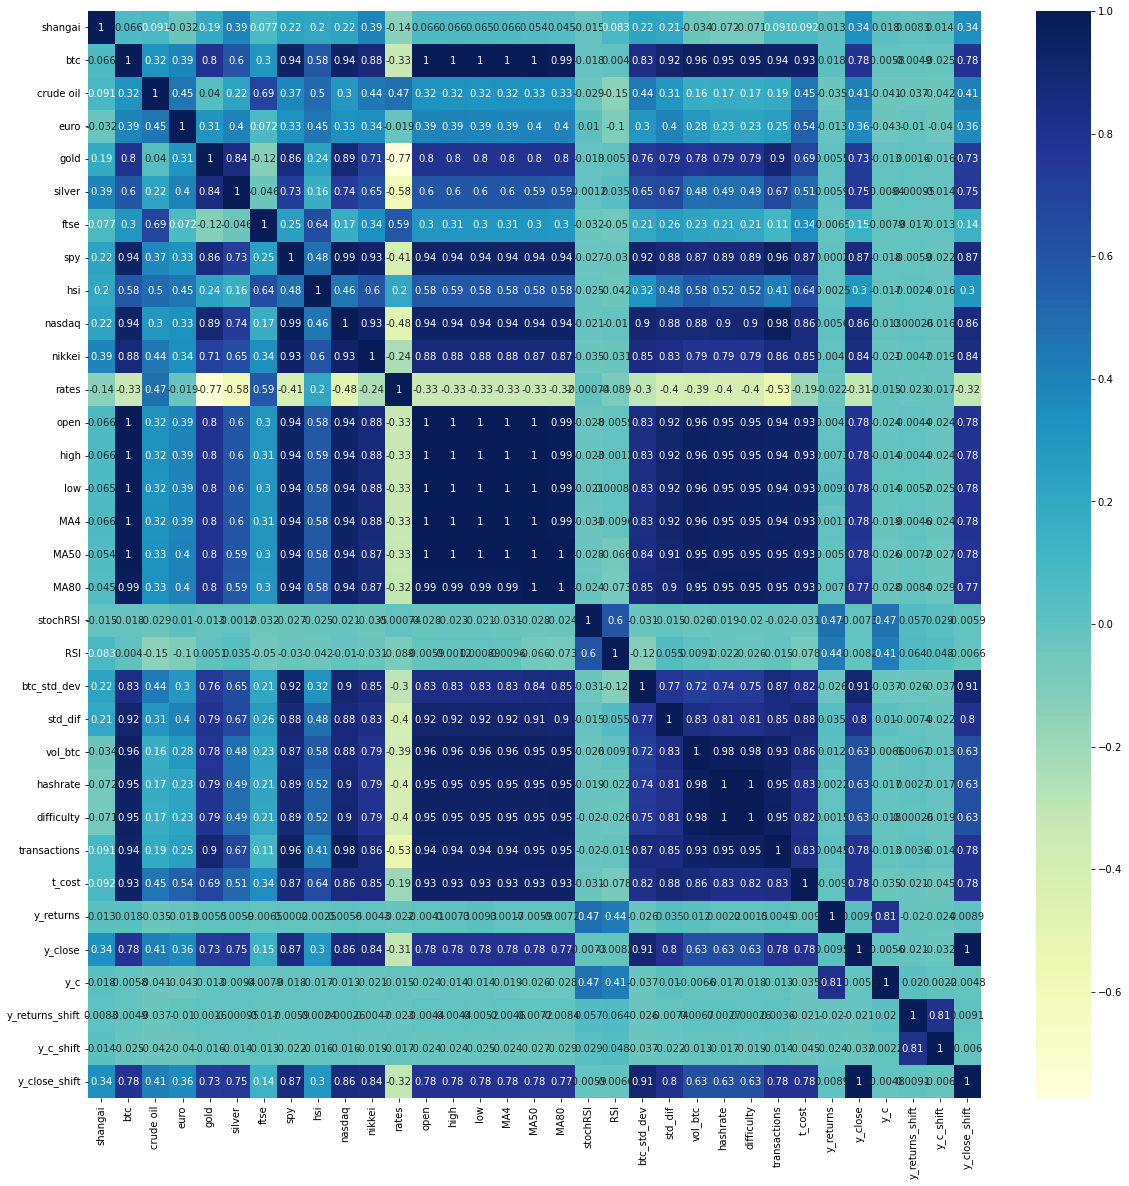

In [40]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, ax=ax,
            annot=True, 
            cmap="YlGnBu")

In [45]:
# Description of normalized features
# print(ndf.shape)
# ndf.describe()

Also interestingly, btc returns (`y_returns`) seem slightly negatively correlated with day-ahead returns.

### Saving the datasets

In [42]:
df_list = [df, ndf, mean, std]
df_path_list = ['data/df.csv', 'data/ndf.csv', 'data/mean.csv', 'data/std.csv']
for (x, y) in zip(df_list, df_path_list):
    x.to_csv(y)

# What comes next?
Ok so, we now have data we can work with! Now it's time to jump into AzureML Studio and go on with the project's
next steps:
- [**Training, tuning & deployment with AutoML**](2-automl.ipynb)
- [**Training & tuning with Hyperdrive**](3-hyperparameter_tuning.ipynb)
